In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import folium
from ipywidgets import interact
from branca.colormap import linear
import geopandas as gpd
import contextily as cx
from shapely.geometry import LineString

In [2]:
# Load data
df = pd.read_csv('AIS_datapoints_ClippedTo_LongIsland.csv')
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'], errors='coerce')
df = df.dropna(subset=['LAT', 'LON', 'MMSI', 'BaseDateTime'])

# Sort by time
df = df.sort_values(by=['MMSI', 'BaseDateTime'])

print(f"Unique vessels: {df['MMSI'].nunique()}")

Unique vessels: 136


In [3]:
# Define a time gap threshold on when to create new tracks(30 mins)
MAX_GAP_SECONDS = 30 * 60

# Compute time differences
df['TimeDiff'] = df.groupby('MMSI')['BaseDateTime'].diff().dt.total_seconds()
df['NewTrack'] = (df['TimeDiff'] > MAX_GAP_SECONDS) | (df['TimeDiff'].isna())

# Assign unique track ID
df['TrackID'] = df.groupby('MMSI')['NewTrack'].cumsum()
df['UniqueTrackID'] = df['MMSI'].astype(str) + '_' + df['TrackID'].astype(str)

print(f"Total unique tracks: {df['UniqueTrackID'].nunique()}")

Total unique tracks: 362


In [4]:
NUM_POINTS = 50

def resample_track(group):
    if len(group) < 10:
        return None
    group = group.sort_values('BaseDateTime').reset_index(drop=True)
    group['time_norm'] = (group['BaseDateTime'] - group['BaseDateTime'].min()).dt.total_seconds()
    group['time_norm'] /= group['time_norm'].max()
    interp_times = np.linspace(0, 1, NUM_POINTS)
    lat_interp = np.interp(interp_times, group['time_norm'], group['LAT'])
    lon_interp = np.interp(interp_times, group['time_norm'], group['LON'])
    return np.concatenate([lat_interp, lon_interp])

# Apply resampling
track_vectors = []
track_ids = []

for track_id, group in df.groupby('UniqueTrackID'):
    result = resample_track(group)
    if result is not None:
        track_vectors.append(result)
        track_ids.append(track_id)

track_vectors = np.array(track_vectors)
print(f"Resampled tracks: {len(track_vectors)}")


Resampled tracks: 246


In [5]:
# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(track_vectors)

# Fit GMM
NUM_CLUSTERS = 6
gmm = GaussianMixture(n_components=NUM_CLUSTERS, random_state=123)
clusters = gmm.fit_predict(X_scaled)

print("Clustering complete.")


Clustering complete.


In [6]:
def plot_all_clusters(n_clusters):
    gmm = GaussianMixture(n_components=n_clusters, random_state=123)
    cluster_labels = gmm.fit_predict(X_scaled)
    palette = sns.color_palette("tab10", n_clusters)
    plt.figure(figsize=(12, 8))
    
    for i in range(n_clusters):
        indices = np.where(cluster_labels == i)[0]
        color = palette[i]
        for j, idx in enumerate(indices):
            track = track_vectors[idx]
            lat = track[:NUM_POINTS]
            lon = track[NUM_POINTS:]
            label = f"Cluster {i}" if j == 0 else None
            plt.plot(lon, lat, color=color, alpha=0.6, linewidth=1.5, label=label)
    
    plt.title(f"Gaussian Mixture (k = {n_clusters})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title='Clusters', loc='best', prop={'size': 15})
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

interact(plot_all_clusters, n_clusters=(2, 10))


interactive(children=(IntSlider(value=6, description='n_clusters', max=10, min=2), Output()), _dom_classes=('w…

<function __main__.plot_all_clusters(n_clusters)>

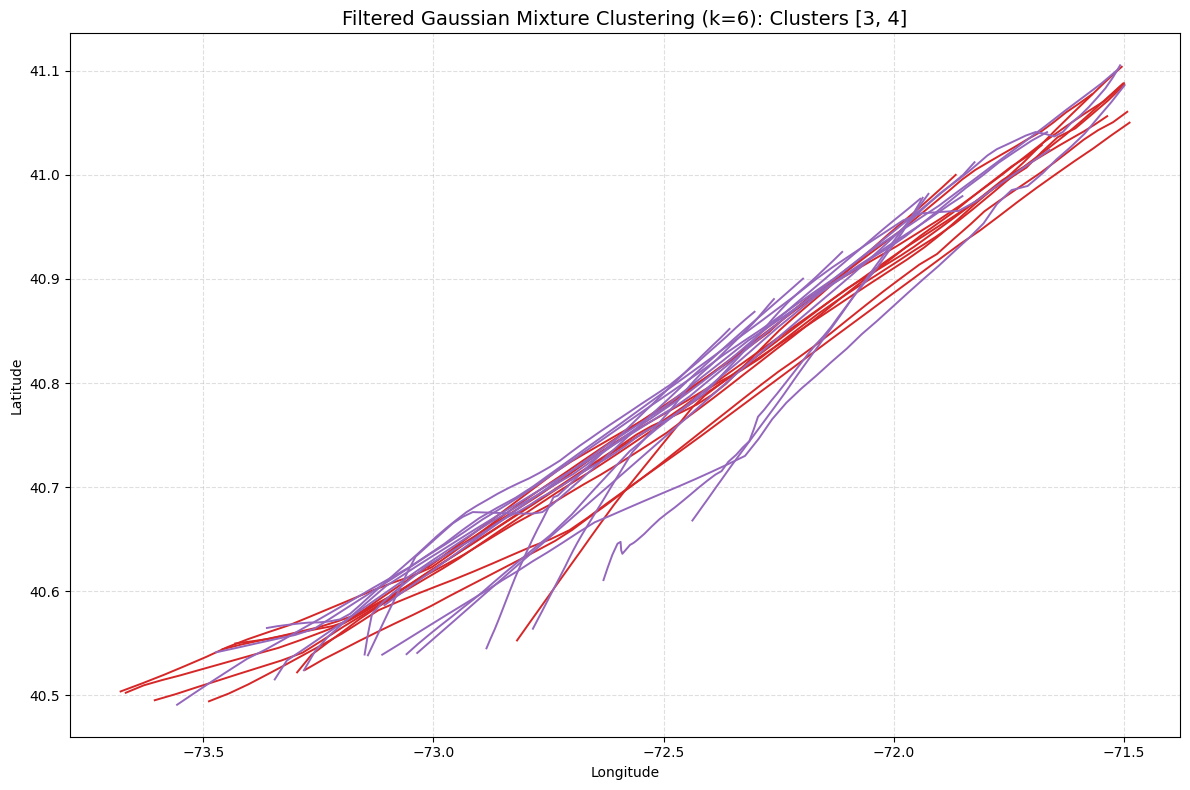

In [7]:
# Define selected clusters to display
selected_clusters = [3, 4]

# Set up seaborn palette
palette = sns.color_palette("tab10", NUM_CLUSTERS)
cluster_colors = [palette[i % 10] for i in selected_clusters]

# Start the plot
plt.figure(figsize=(12, 8))

# Plot each selected cluster
for i in selected_clusters:
    cluster_indices = np.where(clusters == i)[0]
    color = cluster_colors[selected_clusters.index(i)]
    
    for j, idx in enumerate(cluster_indices):
        track = track_vectors[idx]
        lat = track[:NUM_POINTS]
        lon = track[NUM_POINTS:]
        
        # Label only the first track for each cluster
        label = f"Cluster {i}" if j == 0 else None
        plt.plot(lon, lat, color=color, linewidth=1.4, label=label)

# Add legend, grid, labels
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Filtered Gaussian Mixture Clustering (k=6): Clusters {selected_clusters}", fontsize=14)
plt.tight_layout()
plt.show()


In [8]:
# Total unique tracks in GMM result (should equal len(track_ids))
total_tracks = len(track_ids)

# Clusters to keep (e.g., 3 and 5 from GMM with k=6)
selected_clusters = [3, 4]

# Mask and filter track IDs for selected clusters
selected_track_ids = [track_ids[i] for i in range(len(track_ids)) if clusters[i] in selected_clusters]

# Count unique
selected_count = len(set(selected_track_ids))

# Output
print(f"Starting Tracks: {total_tracks}")
print(f"Filtered Tracks: {selected_count}")
print(f"Percentage retained: {selected_count / total_tracks:.2%}")


Starting Tracks: 246
Filtered Tracks: 25
Percentage retained: 10.16%
